In [1]:
from pathlib import Path
import math
import pandas as pd
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.models.resnet import Bottleneck, ResNet
from torchvision.transforms.functional import get_image_size
import matplotlib.pyplot as plt
import albumentations as A


In [2]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, data_df, slice_it=False,
                 slice_width=224,
                 slice_height=224,
                 transform=None):
      self.data_dir = data_dir
      self.labels_df = data_df
      self.transform = transform
      self.slice_it = slice_it
      self.slice_width = slice_width
      self.slice_height = slice_height

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = self.data_dir / f"img_{row['id']}.png"
        image = Image.open(img_path).convert('RGB')
        label = self.labels_df.iloc[idx]['malignant']

        if self.transform:
            if self.slice_it:
              slice_box = row[["xmin", "ymin", "xmax", "ymax"]].values
              ymin = slice_box[1]
              ymax = slice_box[3]
              xmin = slice_box[0]
              xmax = slice_box[2]
              # slice image
              #image = np.array(image)
              #cropped_image = image[ymin:ymax, xmin:xmax:, :]
              image = image.crop((slice_box))
              image = self.transform(image)
            else:
              image = self.transform(image)
              slice_box = None
        sample = {'image': image,
                  'label': label,
                  'id': row['id'],
                  #'slice_bbox': slice_box
                  }
        return sample

In [3]:
def show_imgs(ims, captions=None):
    fig, ax = plt.subplots(nrows=1, ncols=len(ims), figsize=(10, 5))
    for i in range(len(ims)):
        ax[i].imshow(ims[i])
        ax[i].axis('off')
        if captions is not None:
          ax[i].set_title(captions[i], fontweight="bold")

In [4]:
class ResNetTrunk(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        del self.fc  # remove FC layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x


def get_pretrained_url(key):
    URL_PREFIX = "https://github.com/lunit-io/benchmark-ssl-pathology/releases/download/pretrained-weights"
    model_zoo_registry = {
        "BT": "bt_rn50_ep200.torch",
        "MoCoV2": "mocov2_rn50_ep200.torch",
        "SwAV": "swav_rn50_ep200.torch",
    }
    pretrained_url = f"{URL_PREFIX}/{model_zoo_registry.get(key)}"
    return pretrained_url


def resnet50(pretrained, progress, key, **kwargs):
    model = ResNetTrunk(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_url = get_pretrained_url(key)
        verbose = model.load_state_dict(
            torch.hub.load_state_dict_from_url(pretrained_url, progress=progress)
        )
        print(verbose)
    return model



In [5]:
# From: https://towardsdatascience.com/slicing-images-into-overlapping-patches-at-runtime-911fa38618d7
def calculate_slice_bboxes(
    image_height: int,
    image_width: int,
    slice_height: int = 512,
    slice_width: int = 512,
    overlap_height_ratio: float = 0.2,
    overlap_width_ratio: float = 0.2,
) -> list[list[int]]:
    """
    Given the height and width of an image, calculates how to divide the image into
    overlapping slices according to the height and width provided. These slices are returned
    as bounding boxes in xyxy format.
    :param image_height: Height of the original image.
    :param image_width: Width of the original image.
    :param slice_height: Height of each slice
    :param slice_width: Width of each slice
    :param overlap_height_ratio: Fractional overlap in height of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :param overlap_width_ratio: Fractional overlap in width of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :return: a list of bounding boxes in xyxy format
    """

    slice_bboxes = []
    y_max = y_min = 0
    y_overlap = int(overlap_height_ratio * slice_height)
    x_overlap = int(overlap_width_ratio * slice_width)
    while y_max < image_height:
        x_min = x_max = 0
        y_max = y_min + slice_height
        while x_max < image_width:
            x_max = x_min + slice_width
            if y_max > image_height or x_max > image_width:
                xmax = min(image_width, x_max)
                ymax = min(image_height, y_max)
                xmin = max(0, xmax - slice_width)
                ymin = max(0, ymax - slice_height)
                slice_bboxes.append([xmin, ymin, xmax, ymax])
            else:
                slice_bboxes.append([x_min, y_min, x_max, y_max])
            x_min = x_max - x_overlap
        y_min = y_max - y_overlap
    return slice_bboxes

In [6]:
# Set random seed for reproducibility
torch.manual_seed(2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# read in the data
data_dir = Path("/content/data")

In [8]:
# unzip data
! unzip -q /content/data/oxml-carinoma-classification.zip -d /content/data/

In [9]:
labels_file = data_dir / 'labels.csv'
data_df = pd.read_csv(labels_file)

# Transform the class colum to positive values
# Adding +1 otherwise, CUDA throws an error when trying to train
data_df['malignant'] = data_df['malignant'] + 1
data_df

,id,malignant
0,441,0
1,33284,0
2,38771,2
3,46784,0
4,57613,0
...,...,...
57,918503,0
58,931650,0
59,955514,1
60,965412,0


In [10]:
# see how many we ahve from each class
n_healthy = (data_df['malignant'] == 0).sum() # class 0
n_benign = (data_df['malignant'] == 1).sum() # class 1
n_malign = (data_df['malignant'] == 2).sum() # class 2
data_df['malignant'].value_counts()

0    36
1    14
2    12
Name: malignant, dtype: int64

# Load data

In [11]:
# Before we load the data we will create some patches that are all of the same size
all_data = pd.DataFrame(columns=['id', 'image_path', 'h', 'w'])
slices = {}
images_files = data_dir.glob("*.png")

#size of the slices
slice_height = 224
slice_width = 224
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2
for idx, image_file in enumerate(images_files):
  id = int(image_file.stem.split('_')[1])
  img = Image.open(image_file)
  h, w = get_image_size(img)
  slice_bboxes = calculate_slice_bboxes(
    h,
    w,
    slice_height,
    slice_width,
    overlap_height_ratio,
    overlap_width_ratio)
  slices[id] = slice_bboxes
  all_data.loc[idx] = [id, image_file, h, w]

# append the slices values to the df
all_data['slices'] = all_data['id'].map(slices)
all_data

,id,image_path,h,w,slices
0,74682,/content/data/img_74682.png,500,418,"[[0, 0, 224, 224], [180, 0, 404, 224], [194, 0..."
1,467694,/content/data/img_467694.png,396,350,"[[0, 0, 224, 224], [126, 0, 350, 224], [0, 172..."
2,812227,/content/data/img_812227.png,318,496,"[[0, 0, 224, 224], [180, 0, 404, 224], [272, 0..."
3,67212,/content/data/img_67212.png,446,468,"[[0, 0, 224, 224], [180, 0, 404, 224], [244, 0..."
4,243971,/content/data/img_243971.png,446,418,"[[0, 0, 224, 224], [180, 0, 404, 224], [194, 0..."
...,...,...,...,...,...
181,38771,/content/data/img_38771.png,450,450,"[[0, 0, 224, 224], [180, 0, 404, 224], [226, 0..."
182,955514,/content/data/img_955514.png,496,368,"[[0, 0, 224, 224], [144, 0, 368, 224], [0, 180..."
183,957521,/content/data/img_957521.png,368,896,"[[0, 0, 224, 224], [180, 0, 404, 224], [360, 0..."
184,125877,/content/data/img_125877.png,468,450,"[[0, 0, 224, 224], [180, 0, 404, 224], [226, 0..."


In [83]:
print(f"Smallest image size: {all_data['h'].min()}, {all_data['w'].min()}")
print(f"Biggest image size: {all_data['h'].max()}, {all_data['w'].max()}")

Smallest image size: 218, 218
Biggest image size: 896, 896


In [12]:
slices_df = all_data[['id', 'slices']].explode('slices').rename(columns={'slices': 'slice'})
slices_df = pd.DataFrame(slices_df['slice'].tolist(),
                         columns=['xmin', 'ymin', 'xmax', 'ymax'],
                         index=slices_df['id']).reset_index()
slices_df

,id,xmin,ymin,xmax,ymax
0,74682,0,0,224,224
1,74682,180,0,404,224
2,74682,194,0,418,224
3,74682,0,180,224,404
4,74682,180,180,404,404
...,...,...,...,...,...
1442,950085,180,180,404,404
1443,950085,222,180,446,404
1444,950085,0,194,224,418
1445,950085,180,194,404,418


In [44]:
# merge the two dataframes
images_slices_data = pd.merge(slices_df, all_data[['id', 'h', 'w', 'image_path']],
                              how='inner', on='id')
# also merge the diagnostic information. Note, this will select only the training subjects
images_slices_data_train = pd.merge(images_slices_data, data_df[['id', 'malignant']],
                              how='inner', on='id')
images_slices_data_train

,id,xmin,ymin,xmax,ymax,h,w,image_path,malignant
0,74682,0,0,224,224,500,418,/content/data/img_74682.png,1
1,74682,180,0,404,224,500,418,/content/data/img_74682.png,1
2,74682,194,0,418,224,500,418,/content/data/img_74682.png,1
3,74682,0,180,224,404,500,418,/content/data/img_74682.png,1
4,74682,180,180,404,404,500,418,/content/data/img_74682.png,1
...,...,...,...,...,...,...,...,...,...
470,955514,144,0,368,224,496,368,/content/data/img_955514.png,1
471,955514,0,180,224,404,496,368,/content/data/img_955514.png,1
472,955514,144,180,368,404,496,368,/content/data/img_955514.png,1
473,955514,0,272,224,496,496,368,/content/data/img_955514.png,1


In [16]:
slice_it = True

if slice_it == True:
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(0.25), # augment the data
      transforms.RandomVerticalFlip(0.25),
      transforms.ToTensor(),
      # Rescale pixel to [-1, 1] values.
      # The first tuple (0.5, 0.5, 0.5) is the mean for all three
      # channels and the second (0.5, 0.5, 0.5) is the standard
      # deviation for all three channels.
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])
  dataset = CustomDataset(data_dir, images_slices_data_train, slice_it=slice_it,
                        slice_width=slice_width,
                        slice_height=slice_height,
                        transform=transform)
else:
  transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(0.25), # augment the data
      transforms.RandomVerticalFlip(0.25),
      transforms.ToTensor(),
      # Rescale pixel to [-1, 1] values.
      # The first tuple (0.5, 0.5, 0.5) is the mean for all three
      # channels and the second (0.5, 0.5, 0.5) is the standard
      # deviation for all three channels.
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])
  # Create the custom dataset
  dataset = CustomDataset(data_dir, images_slices_data_train, slice_it=slice_it,
                        slice_width=None,
                        slice_height=None,
                        transform=transform)

In [17]:
# Create the data loader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
len(dataloader)

30

In [19]:
sample = next(iter(dataloader))
print(f"Len dataloader: {len(dataloader)}")
print(f"Image shape: {sample['image'].shape} Labels shape: {sample['label'].shape}")

Len dataloader: 30
Image shape: torch.Size([16, 3, 224, 224]) Labels shape: torch.Size([16])


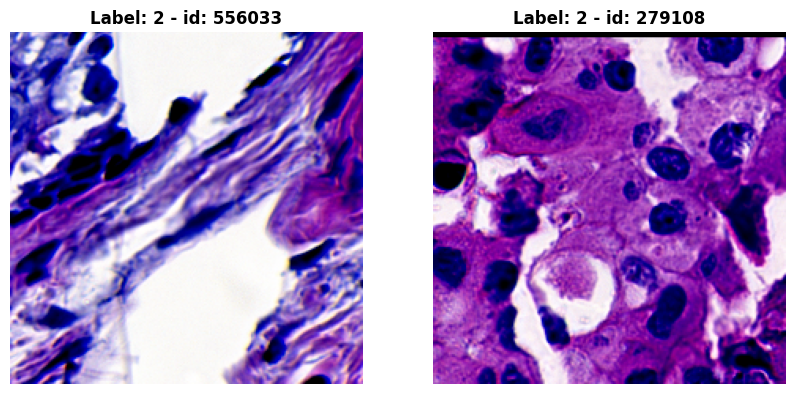

In [20]:
show_imgs([sample["image"][1].permute(1, 2, 0), sample["image"][2].permute(1, 2, 0)],
          captions=[f"Label: {sample['label'][1]} - id: {sample['id'][1]}",
                    f"Label: {sample['label'][2]} - id: {sample['id'][2]}"])

# Get a pre-trained model
Here I will use the models [from](https://github.com/lunit-io/benchmark-ssl-pathology)

In [21]:
# add Fully connected linear layer
class Resnet_fc(nn.Module):
  def __init__(self, pre_trained_model):
    super(Resnet_fc, self).__init__()
    n_classes = 3
    self.model = pre_trained_model
    #self.fc = nn.Sequential(nn.Linear(2048*7, 7),
                            #nn.ReLU(),
                            #nn.Linear(7, 3))
    self.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048*7*7, n_classes))

  def forward(self, x):
    x = self.model(x)
    x = self.fc(x)
    return x

In [22]:
# Create a last fully connected layer to match the number of classes
# Note: the number of of nodes was determined by looking at the network

num_classes = 3
pre_trained_model = resnet50(pretrained=True, progress=False, key="MoCoV2")

# Freeze the parameters in the pre-trained network
for param in pre_trained_model.parameters():
    param.requires_grad = False

# Add the fully connected layer that we want to optmize
model = Resnet_fc(pre_trained_model)
model.to(device)


Downloading: "https://github.com/lunit-io/benchmark-ssl-pathology/releases/download/pretrained-weights/mocov2_rn50_ep200.torch" to /root/.cache/torch/hub/checkpoints/mocov2_rn50_ep200.torch


<All keys matched successfully>


Resnet_fc(
  (model): ResNetTrunk(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [23]:
# note that only the last parameters will be optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# Define the loss function
# use weights to balance out the imbalanced classification
weights = [1/n_healthy, 1/n_benign, 1/n_malign]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-4, patience=500)

In [26]:
num_epochs = 200
epoch_loss_list = []
epoch_lr = []
model.train()
verbose = False
for epoch in range(num_epochs):
  running_loss = 0.0
  for inputs in dataloader:
    images = inputs["image"].to(device)
    labels = inputs["label"].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

  epoch_loss = running_loss / len(dataloader)
  epoch_loss_list.append(epoch_loss)
  epoch_lr.append(get_lr(optimizer))
  if verbose:
    print('-' * 10)
    print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f}")
  else:
    if (int(epoch) % 10) == 0:
      print('-' * 10)
      print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f}")



----------
Epoch 0/200 - Loss: 1.0158
----------
Epoch 50/200 - Loss: 0.2452
----------
Epoch 100/200 - Loss: 0.2312
----------
Epoch 150/200 - Loss: 0.2341


Text(0, 0.5, 'Loss')

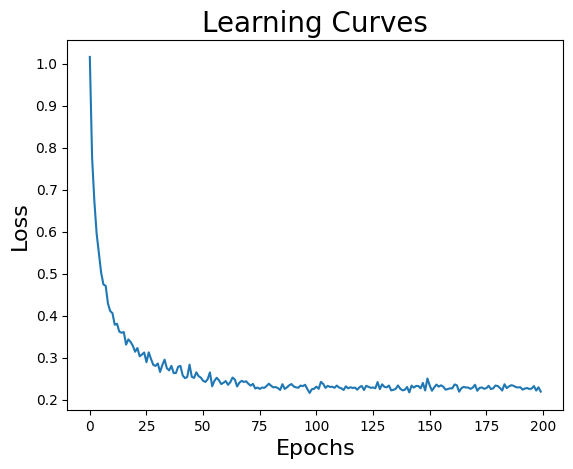

In [27]:
plt.plot(epoch_loss_list)
plt.title("Learning Curves", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

Text(0, 0.5, 'Loss')

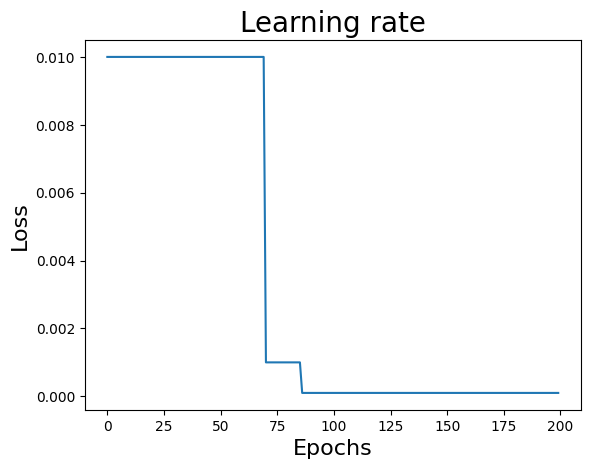

In [28]:
plt.plot(epoch_lr)
plt.title("Learning rate", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

# Get the test labels

In [76]:
output = {}
output_df = pd.DataFrame(columns=['id', 'malignant'])
if slice_it:
  # remove the training samples
  images_slices_data_test = images_slices_data[~images_slices_data['id'].isin(images_slices_data_train['id'])]
  for idx, row in images_slices_data_test.iterrows():
    slice_box = row[["xmin", "ymin", "xmax", "ymax"]].values
    # Load image
    image = Image.open(image_file).convert('RGB')
    image = image.crop((slice_box))
    data = transform(image).to(device)
    # Add Batch dimension
    data = torch.unsqueeze(data, 0)
    # pass image to the model
    label = torch.argmax(model(data)).cpu().detach().numpy()
    output_df.loc[idx] = [row['id'], label]
  # select the highest value
  output_df = output_df.groupby(['id']).max().reset_index()
  output_df['malignant'] = output_df['malignant'] - 1

else:
  images_files = data_dir.glob("*.png")
  # remove files that we have labels for
  training_ids = data_df['id'].to_list()
  test_ids = []
  for idx, image_file in enumerate(images_files):
    id = int(image_file.stem.split('_')[1])

    if id not in training_ids:
      test_ids.append(id)

      # Load image
      image = Image.open(image_file).convert('RGB')
      data = transform(image).to(device)
      # Add Batch dimension
      data = torch.unsqueeze(data, 0)

      # pass image to the model
      label = torch.argmax(model(data)).cpu().detach().numpy() - 1

      output_df.loc[idx] = [id, label]

  print(f'Number of unlabelled images: {len(test_ids)}')

In [77]:
output_df

,id,malignant
0,5042,-1
1,28148,-1
2,35946,1
3,37944,-1
4,39157,-1
...,...,...
119,959476,0
120,968389,0
121,976505,0
122,996288,-1


In [78]:
output_df['malignant'].value_counts()

-1    72
 0    35
 1    17
Name: malignant, dtype: int64

In [79]:
# save output
output_df.to_csv(data_dir / 'predictions.csv', index=False)